In [9]:
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import words as nltk_words
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline , FeatureUnion
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
import re
import sys
import string
from time import time
import numpy as np
import itertools
from sklearn import metrics
DATASET_PATH = 'gender-classifier-DFE-791531.csv'
stop = set(stopwords.words('english'))
tokenizer = TweetTokenizer()



In [10]:
# data = pd.read_csv(DATASET_PATH, encoding='utf-8',  index_col=False)#sep='\t' header=None,
data = pd.read_csv(DATASET_PATH, encoding='latin1',  index_col=False)#sep='\t' header=None,

df = pd.DataFrame(data)

#filtering out some columns that we will not use:
df.drop(['_golden','_unit_state','_trusted_judgments','_last_judgment_at','profile_yn','profile_yn:confidence',
        'created','fav_number','gender_gold','profile_yn_gold','profileimage','retweet_count','tweet_coord',
        'tweet_count','tweet_created','tweet_id','tweet_location','user_timezone'], axis=1,inplace=True)

df.head(10)

,_unit_id,gender,gender:confidence,description,link_color,name,sidebar_color,text
0,815719226,male,1.0000,i sing my own rhythm.,08C2C2,sheezy0,FFFFFF,Robbie E Responds To Critics After Win Against...
1,815719227,male,1.0000,I'm the author of novels filled with family dr...,0084B4,DavdBurnett,C0DEED,â°ï¢Ö¿It felt like they were my friends and ...
2,815719228,male,0.6625,louis whining and squealing and all,ABB8C2,lwtprettylaugh,C0DEED,i absolutely adore when louis starts the songs...
3,815719229,male,1.0000,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",0084B4,douggarland,C0DEED,Hi @JordanSpieth - Looking at the url - do you...
4,815719230,female,1.0000,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,3B94D9,WilfordGemma,0,Watching Neighbours on Sky+ catching up with t...
5,815719231,female,1.0000,you don't know me.,F5ABB5,monroevicious,0,"Ive seen people on the train with lamps, chair..."
6,815719232,brand,1.0000,"A global marketplace for images, videos and mu...",298AAE,Shutterstock,0,@BpackEngineer Thank you for your patience whi...
7,815719233,male,1.0000,The secret of getting ahead is getting started.,0000FF,RobinMeske,C0DEED,Gala Bingo clubs bought for ×Â£241m: The UK's...
8,815719234,female,1.0000,Pll Fan // Crazy about MCD // Ramen is bae,9266CC,pigzilla_,0,@_Aphmau_ the pic defines all mcd fangirls/fan...
9,815719235,female,1.0000,"Renaissance art historian, University of Notti...",9266CC,GabrieleNeher,FFFFFF,@Evielady just how lovely is the tree this yea...


In [11]:
def fix_nan_description(description):
    if type(description) is float:
        return ''
#     if description.encode('latin-1').strip() == 'nan':
    if description.strip() == 'nan':
        return ''
    return description

#for example:
fix_nan_description('nan ')

''

In [12]:
def stem(text):
    tokens = tokenizer.tokenize(text)
    ps = PorterStemmer()
    
    tokens = [ps.stem(token) for token in tokens]
    
    return ' '.join(tokens)

#for example:
stem('regardless of context, their affection seemed non-existant')

def remove_stop_words(text):
    tokens = tokenizer.tokenize(text)
    stop = set(stopwords.words('english'))
    
    tokens = [token for token in tokens if token not in stop]
    
    return ' '.join(tokens)

#for example:
remove_stop_words('regardless of context, their affection seemed non-existant')

def remove_punctuation(text):
    tokens = [token for token in tokenizer.tokenize(text) if token not in string.punctuation]
    return ' '.join(tokens)


def remove_url(text):    
    return re.sub(r'https?:\S+', '', text)

#for example:
remove_url('for more info on http, enter http://www.http.com (lo beshabat)')

def remove_hashtags(text,mode):  
    if mode == 'entire_expression':
        return re.sub(r'#\S+', '', text)
    elif mode == 'only_symbol':
        return text.replace('#','')
    else:
        return text

#for example:
remove_hashtags('what did you think about the # of voters this year? use #VotersUnite to let us know.','entire_expression')

remove_hashtags('#fridaymadness #nature #fun #outdoor #originalperson','only_symbol')

def remove_ats(text,mode):
    if mode == 'entire_expression':
        return re.sub(r'@\S+', '', text)
    elif mode == 'only_symbol':
        return str(text).replace('@','')
    else:
        return text
    
#for example:
remove_ats('@ameliaearhart vs @WrightBrothers in an all exclusive fly-off','entire_expression')

remove_ats('@ameliaearhart vs @WrightBrothers in an all exclusive fly-off','only_symbol')

def remove_multiple_spaces(text):    
    return re.sub(r' +', ' ', text).strip()

#for example:
remove_multiple_spaces(' @ameliaearhart       vs   @WrightBrothers in an all   exclusive fly-off ')

'@ameliaearhart vs @WrightBrothers in an all exclusive fly-off'

In [13]:
def preprocess(df, min_confidence=0.9, should_lower=False, should_stem=False, should_remove_stop_words=False, should_remove_url=False,
                            should_remove_punctuation=False,should_remove_hashtags='none',should_remove_ats='none'):
    
    #basic cleaning
    cleaner_df = df.loc[(df['gender'] != 'nan') & (df['text'] != 'nan') & (df['gender'] != 'unknown')]
    
    cleaner_df = cleaner_df[df['gender:confidence'] >= min_confidence]
            
    
    
    cleaner_df['description'] = [fix_nan_description(desc) for desc in cleaner_df['description']]

    
    #################################
    #removing spam tweets:
    cleaner_df.drop_duplicates(subset='text', keep='first', inplace=True)
    ##################################
    

    #todo probably sucks
    if should_lower:
        cleaner_df['description'] = [desc.lower() for desc in cleaner_df['description']]
        cleaner_df['text'] = [text.lower() for text in cleaner_df['text']]

    #todo check this (probably sucks so leave it out)
    if should_remove_punctuation:
        cleaner_df['description'] = [remove_punctuation(desc) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_punctuation(text) for text in cleaner_df['text']]

    if should_remove_url:
        cleaner_df['description'] = [remove_url(desc) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_url(text) for text in cleaner_df['text']]
        
    if should_remove_hashtags!='none':
        cleaner_df['description'] = [remove_hashtags(desc,should_remove_hashtags) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_hashtags(text,should_remove_hashtags) for text in cleaner_df['text']]
        
    if should_remove_ats!='none':
        cleaner_df['description'] = [remove_ats(desc,should_remove_ats) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_ats(text,should_remove_ats) for text in cleaner_df['text']]
          
    if should_remove_stop_words:
        cleaner_df['description'] = [remove_stop_words(desc) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_stop_words(text) for text in cleaner_df['text']]


    if should_stem:
        cleaner_df['description'] = [stem(desc) for desc in cleaner_df['description']]
        cleaner_df['text'] = [stem(text) for text in cleaner_df['text']]
        

    #remove multiple spaces
    cleaner_df['description'] = [remove_multiple_spaces(desc) for desc in cleaner_df['description']]
    cleaner_df['text'] = [remove_multiple_spaces(text) for text in cleaner_df['text']]
    cleaner_df['text_desc'] = [desc+' '+text for desc,text in zip(cleaner_df['description'],cleaner_df['text'])]

    return cleaner_df

In [14]:
clean_df = preprocess(df)
print('Number of records: {}'.format(len(clean_df['text'])))

W:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Number of records: 13165


In [15]:
import keras
import keras.preprocessing.text as kpt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

#same split as with the above model
x_train = clean_df['text_desc'][:int(0.9*len(clean_df))]

gender_to_int = {'female':0,'male':1,'brand':2}

y_train = list([gender_to_int[gender] for gender in clean_df['gender'][:int(0.9*len(clean_df))]]) 
y_train = keras.utils.to_categorical(y_train, 3)


Using TensorFlow backend.


In [16]:
N_WORDS = 10000

keras_tokenizer = kpt.Tokenizer(filters='', lower=True,split = ' ',num_words=N_WORDS)#configuring the keras tokenizer to do close to nothing in terms of tokenization

texts_for_keras_tokenizer = list([' '.join(tokenizer.tokenize(text)) for text in x_train]) 

keras_tokenizer.fit_on_texts(texts_for_keras_tokenizer)

x_train = keras_tokenizer.texts_to_matrix(texts_for_keras_tokenizer, mode='binary')


#todo optimize this
model = Sequential()#initialize the NN

#add a layer that gets N_WORDS inputs (this is the BOW representation of any tweet) and outputs 512 values ()
model.add(Dense(512, input_shape=(N_WORDS,), activation='relu'))

model.add(Dropout(0.5))


model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(3, activation='softmax'))# this gives a distribution over all 3 genders (probability of the input's belonging to any of the gender)
model.compile(loss='categorical_crossentropy',  optimizer='adam',  metrics=['accuracy']) 
# model.compile(loss='categorical_crossentropy',  optimizer='rmsprop',  metrics=['accuracy'])

#we are using the x,y we constructed earlier,
model.fit(x_train, y_train,  batch_size=32,  epochs=10,  verbose=1,  validation_split=0.1,  shuffle=True)


Train on 10663 samples, validate on 1185 samples
Epoch 1/10
10663/10663 [==============================] - 27s 2ms/step - loss: 0.8192 - acc: 0.6072 - val_loss: 0.7202 - val_acc: 0.6616
Epoch 2/10
10663/10663 [==============================] - 25s 2ms/step - loss: 0.5113 - acc: 0.7845 - val_loss: 0.7507 - val_acc: 0.6759
Epoch 3/10
10663/10663 [==============================] - 25s 2ms/step - loss: 0.2782 - acc: 0.8965 - val_loss: 0.9113 - val_acc: 0.6709
Epoch 4/10
10663/10663 [==============================] - 25s 2ms/step - loss: 0.1257 - acc: 0.9575 - val_loss: 1.1831 - val_acc: 0.6768
Epoch 5/10
10663/10663 [==============================] - 26s 2ms/step - loss: 0.0685 - acc: 0.9805 - val_loss: 1.3566 - val_acc: 0.6346
Epoch 6/10
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0543 - acc: 0.9860 - val_loss: 1.4801 - val_acc: 0.6591
Epoch 7/10
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0362 - acc: 0.9913 - val_loss: 1.5971 - val_acc:

In [17]:
x_test = clean_df['text_desc'][int(0.9*len(clean_df)):]

y_test = list([gender_to_int[gender] for gender in clean_df['gender'][int(0.9*len(clean_df)):]]) 

texts_for_keras_tokenizer = list([' '.join(tokenizer.tokenize(text)) for text in x_test]) 


x_test = keras_tokenizer.texts_to_matrix(texts_for_keras_tokenizer, mode='binary')

keras_pred = model.predict(x_test)

In [18]:
int_to_gender = {0: 'female',1:'male',2:'brand'}

actual_pred = list([np.argmax(values) for values in keras_pred])

#todo write things
print(classification_report(y_test, actual_pred))
print('Accuracy score: {}'.format(accuracy_score(y_test, actual_pred)))

             precision    recall  f1-score   support

          0       0.71      0.68      0.69       619
          1       0.57      0.52      0.54       425
          2       0.67      0.84      0.74       273

avg / total       0.66      0.66      0.66      1317

Accuracy score: 0.659832953682612


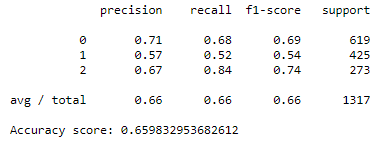

In [19]:
def preprocessing_combinations(df_training, df_test):
    #this produces a list of tuples which are all the possible arrangements of True,False among the cleaning steps we will use
    parameter_possibilities = list(itertools.product([0, 1], repeat=7))
    
    lower_possibility_index = 0
    stem_possibility_index = 1
    remove_stop_words_possibility_index = 2
    remove_url_possibility_index = 3
    remove_punctuation_possibility_index = 4
    remove_hashtags_possibility_index = 5
    remove_ats_possibility_index = 6

    #this will be a list of tuples.
    res = []
    
    for possibility in parameter_possibilities:
        is_lower = bool(possibility[lower_possibility_index])
        is_stemming = bool(possibility[stem_possibility_index])
        is_remove_stop_words = bool(possibility[remove_stop_words_possibility_index])
        is_remove_url = bool(possibility[remove_url_possibility_index])
        is_remove_punctuation = bool(possibility[remove_punctuation_possibility_index])
        is_remove_hashtags = bool(possibility[remove_hashtags_possibility_index])
        is_remove_hashtags = 'only_symbol' if is_remove_hashtags else 'none'
        is_remove_ats = bool(possibility[remove_ats_possibility_index])
        is_remove_ats = 'entire_expression' if is_remove_ats else 'none'

        
        current_training  = preprocess(df_training, 
                                       should_lower=is_lower,
                                       should_stem=is_stemming,
                                       should_remove_stop_words=is_remove_stop_words,
                                       should_remove_url=is_remove_url,
                                       should_remove_punctuation=is_remove_punctuation,
                                       should_remove_hashtags = is_remove_hashtags,
                                       should_remove_ats = is_remove_ats)
        current_test  = preprocess(df_test, 
                                       should_lower=is_lower,
                                       should_stem=is_stemming,
                                       should_remove_stop_words=is_remove_stop_words,
                                       should_remove_url=is_remove_url,
                                       should_remove_punctuation=is_remove_punctuation,
                                       should_remove_hashtags = is_remove_hashtags,
                                       should_remove_ats = is_remove_ats)

        current_tag= '\nlower : ' + str(is_lower)
        current_tag+= '\nstemming : ' + str(is_stemming)
        current_tag+= '\nremove stop words : '+str(is_remove_stop_words)
        current_tag+= '\nremove urls : '+str(is_remove_url)
        current_tag+= '\nremove punctuation : '+str(is_remove_punctuation)
        current_tag+= '\nremove hashtags : '+str(is_remove_hashtags)
        current_tag+= '\nremove ats : '+str(is_remove_ats)

        tagged_clean_dataset = (current_training , current_test , current_tag)
        
        res.append(tagged_clean_dataset)
    
    return res

In [20]:
training_df = clean_df[:int(0.9*len(clean_df))]#note that the df we use here was cleaned only from spam and irrelevant records. we will now clean it further
test_df = clean_df[int(0.9*len(clean_df)):]

combinations = preprocessing_combinations(training_df,test_df)


In [21]:
i=0
dl_exact_accuracies = []
dl_precisions = []
dl_recalls = []
dl_f_measures = []
N_WORDS = 10000
gender_to_int = {'female':0,'male':1,'brand':2}
int_to_gender = {0: 'female',1:'male',2:'brand'}
for combination in combinations:
    x_train_df = combination[0]
    x_train = x_train_df['text_desc']
    y_train = combination[0]['gender']
    y_train = list([gender_to_int[gender] for gender in y_train]) 
    y_train = keras.utils.to_categorical(y_train, 3)
    x_test_df = combination[1]
    x_test = x_test_df['text_desc']
    y_test = combination[1]['gender']
    y_test = list([gender_to_int[gender] for gender in y_test]) 
#     y_test = keras.utils.to_categorical(y_test, 3)
    tag = combination[2]

    keras_tokenizer = kpt.Tokenizer(filters='',split = ' ',num_words=N_WORDS)#configuring the keras tokenizer to do close to nothing in terms of tokenization

    texts_for_keras_tokenizer = list([' '.join(tokenizer.tokenize(text)) for text in x_train]) 

    keras_tokenizer.fit_on_texts(texts_for_keras_tokenizer)

    x_train = keras_tokenizer.texts_to_matrix(texts_for_keras_tokenizer, mode='binary')


    #todo optimize this
    model = Sequential()#initialize the NN

    #add a layer that gets N_WORDS inputs (this is the BOW representation of any tweet) and outputs 512 values ()
    model.add(Dense(512, input_shape=(N_WORDS,), activation='relu'))

    model.add(Dropout(0.5))


    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))


    model.add(Dense(3, activation='softmax'))# this gives a distribution over all 3 genders (probability of the input's belonging to any of the gender)
    model.compile(loss='categorical_crossentropy',  optimizer='adam',  metrics=['accuracy']) 
    
    
    print('Training with combination number '+str(i)+'/'+str(len(combinations)))
    
    
    details = '\n\nPreprocessing parameters:\n'+tag
    

    t0 = time()
    model.fit(x_train, y_train,  batch_size=32,  epochs=7,  verbose=1,  validation_split=0.1,  shuffle=True)
    train_time = time() - t0
    details+="\nFeature extraction + training time: %0.3fs" % train_time
    
    t0 = time()
    
#     pred = baseline.predict(x_test)
    texts_for_keras_tokenizer = list([' '.join(tokenizer.tokenize(text)) for text in x_test]) 
    x_test = keras_tokenizer.texts_to_matrix(texts_for_keras_tokenizer, mode='binary')

    keras_pred = model.predict(x_test)

    actual_pred = list([np.argmax(values) for values in keras_pred])

    test_time = time() - t0
    details+="\nTest time:  %0.3fs" % test_time

    exact_accuracy = metrics.accuracy_score(y_test, actual_pred)
    details+="\n\nAccuracy:   %0.3f" % exact_accuracy

    details+='\nMicro-averaged metrics: '

    precision_micro = metrics.precision_score(y_test, actual_pred, average='micro')
    details+="\nPrecision:   %0.3f" % precision_micro

    recall_micro = metrics.recall_score(y_test, actual_pred, average='micro')
    details+="\nRecall:   %0.3f" % recall_micro

    f_measure_micro = metrics.f1_score(y_test, actual_pred, average='micro')                              
    details+="\nF_measure:   %0.3f" % f_measure_micro

    details+='\nMacro-averaged metrics: '

    precision_macro = metrics.precision_score(y_test, actual_pred, average='macro')
    details+="\nPrecision:   %0.3f" % precision_macro

    recall_macro = metrics.recall_score(y_test, actual_pred, average='macro')
    details+="\nRecall:   %0.3f" % recall_macro

    f_measure_macro = metrics.f1_score(y_test, actual_pred, average='macro')                              
    details+="\nF_measure:   %0.3f" % f_measure_macro

    details+='\nWeighted-average metrics: '

    precision_weighted = metrics.precision_score(y_test, actual_pred, average='weighted')
    details+="\nPrecision:   %0.3f" % precision_weighted

    recall_weighted = metrics.recall_score(y_test, actual_pred, average='weighted')
    details+="\nRecall:   %0.3f" % recall_weighted

    f_measure_weighted = metrics.f1_score(y_test, actual_pred, average='weighted')                              
    details+="\nF_measure:   %0.3f" % f_measure_weighted
        
        
    dl_exact_accuracies.append((exact_accuracy,details))
    dl_precisions.append((max(precision_micro,precision_macro,precision_weighted),details))    
    dl_recalls.append((max(recall_micro,recall_macro,recall_weighted),details))
    dl_f_measures.append((max(f_measure_micro,f_measure_macro,f_measure_weighted),details))
    
    i+=1

Training with combination number 0/128
Train on 10663 samples, validate on 1185 samples
Epoch 1/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.8130 - acc: 0.6079 - val_loss: 0.7096 - val_acc: 0.6675
Epoch 2/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.5167 - acc: 0.7775 - val_loss: 0.7506 - val_acc: 0.6641
Epoch 3/7
10663/10663 [==============================] - 24s 2ms/step - loss: 0.2643 - acc: 0.9006 - val_loss: 0.9423 - val_acc: 0.6616
Epoch 4/7
10663/10663 [==============================] - 24s 2ms/step - loss: 0.1218 - acc: 0.9586 - val_loss: 1.2033 - val_acc: 0.6506
Epoch 5/7
10663/10663 [==============================] - 24s 2ms/step - loss: 0.0745 - acc: 0.9808 - val_loss: 1.2775 - val_acc: 0.6641
Epoch 6/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0400 - acc: 0.9899 - val_loss: 1.5931 - val_acc: 0.6641
Epoch 7/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0401 - acc: 0.98

10663/10663 [==============================] - 25s 2ms/step - loss: 0.0335 - acc: 0.9908 - val_loss: 1.7124 - val_acc: 0.6574
Training with combination number 8/128
Train on 10663 samples, validate on 1185 samples
Epoch 1/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.8156 - acc: 0.6066 - val_loss: 0.7179 - val_acc: 0.6464
Epoch 2/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.5243 - acc: 0.7858 - val_loss: 0.7339 - val_acc: 0.6658
Epoch 3/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.2791 - acc: 0.8959 - val_loss: 0.9138 - val_acc: 0.6726
Epoch 4/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.1292 - acc: 0.9570 - val_loss: 1.1469 - val_acc: 0.6675
Epoch 5/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.0745 - acc: 0.9781 - val_loss: 1.3788 - val_acc: 0.6641
Epoch 6/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.0433 - acc: 0.9870 - val_l

10663/10663 [==============================] - 24s 2ms/step - loss: 0.0570 - acc: 0.9845 - val_loss: 1.5199 - val_acc: 0.6498
Epoch 6/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0409 - acc: 0.9888 - val_loss: 1.6663 - val_acc: 0.6439
Epoch 7/7
10663/10663 [==============================] - 24s 2ms/step - loss: 0.0391 - acc: 0.9892 - val_loss: 1.7253 - val_acc: 0.6388
Training with combination number 24/128
Train on 10663 samples, validate on 1185 samples
Epoch 1/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.8237 - acc: 0.6032 - val_loss: 0.7286 - val_acc: 0.6658
Epoch 2/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.5065 - acc: 0.7932 - val_loss: 0.7606 - val_acc: 0.6785
Epoch 3/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.2450 - acc: 0.9110 - val_loss: 1.0025 - val_acc: 0.6540
Epoch 4/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.1100 - acc: 0.9659 - val_

10663/10663 [==============================] - 25s 2ms/step - loss: 0.2940 - acc: 0.8874 - val_loss: 0.9469 - val_acc: 0.6481
Epoch 4/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.1306 - acc: 0.9558 - val_loss: 1.2395 - val_acc: 0.6481
Epoch 5/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0716 - acc: 0.9781 - val_loss: 1.5237 - val_acc: 0.6245
Epoch 6/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0486 - acc: 0.9877 - val_loss: 1.7100 - val_acc: 0.6219
Epoch 7/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.0349 - acc: 0.9899 - val_loss: 1.6884 - val_acc: 0.6346
Training with combination number 40/128
Train on 10663 samples, validate on 1185 samples
Epoch 1/7
10663/10663 [==============================] - 29s 3ms/step - loss: 0.8243 - acc: 0.6040 - val_loss: 0.7255 - val_acc: 0.6658
Epoch 2/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.5402 - acc: 0.7719 - val_

10663/10663 [==============================] - 28s 3ms/step - loss: 0.8391 - acc: 0.5989 - val_loss: 0.7544 - val_acc: 0.6489
Epoch 2/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.5248 - acc: 0.7862 - val_loss: 0.8277 - val_acc: 0.6287
Epoch 3/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.2728 - acc: 0.8936 - val_loss: 0.9962 - val_acc: 0.6363
Epoch 4/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.1193 - acc: 0.9628 - val_loss: 1.2958 - val_acc: 0.6354
Epoch 5/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0616 - acc: 0.9826 - val_loss: 1.5327 - val_acc: 0.6143
Epoch 6/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0435 - acc: 0.9892 - val_loss: 1.6976 - val_acc: 0.6219
Epoch 7/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0380 - acc: 0.9905 - val_loss: 1.7571 - val_acc: 0.6278
Training with combination number 56/128
Train on 10663 sam

Training with combination number 63/128
Train on 10663 samples, validate on 1185 samples
Epoch 1/7
10663/10663 [==============================] - 28s 3ms/step - loss: 0.8346 - acc: 0.6010 - val_loss: 0.7541 - val_acc: 0.6422
Epoch 2/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.5179 - acc: 0.7786 - val_loss: 0.8113 - val_acc: 0.6380
Epoch 3/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.2690 - acc: 0.8988 - val_loss: 1.0058 - val_acc: 0.6371
Epoch 4/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.1207 - acc: 0.9600 - val_loss: 1.3509 - val_acc: 0.6338
Epoch 5/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.0661 - acc: 0.9809 - val_loss: 1.5490 - val_acc: 0.6321
Epoch 6/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.0431 - acc: 0.9876 - val_loss: 1.7015 - val_acc: 0.6439
Epoch 7/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0440 - acc: 0.9

10663/10663 [==============================] - 25s 2ms/step - loss: 0.0404 - acc: 0.9903 - val_loss: 1.6103 - val_acc: 0.6667
Training with combination number 71/128
Train on 10663 samples, validate on 1185 samples
Epoch 1/7
10663/10663 [==============================] - 28s 3ms/step - loss: 0.8202 - acc: 0.6033 - val_loss: 0.7181 - val_acc: 0.6591
Epoch 2/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.5083 - acc: 0.7902 - val_loss: 0.7581 - val_acc: 0.6641
Epoch 3/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.2641 - acc: 0.9042 - val_loss: 0.9131 - val_acc: 0.6608
Epoch 4/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.1123 - acc: 0.9640 - val_loss: 1.1996 - val_acc: 0.6565
Epoch 5/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.0607 - acc: 0.9833 - val_loss: 1.4423 - val_acc: 0.6557
Epoch 6/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.0456 - acc: 0.9875 - val_

10663/10663 [==============================] - 25s 2ms/step - loss: 0.0524 - acc: 0.9853 - val_loss: 1.7074 - val_acc: 0.6515
Epoch 6/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.0400 - acc: 0.9896 - val_loss: 1.7642 - val_acc: 0.6582
Epoch 7/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0328 - acc: 0.9916 - val_loss: 1.8957 - val_acc: 0.6388
Training with combination number 87/128
Train on 10663 samples, validate on 1185 samples
Epoch 1/7
10663/10663 [==============================] - 28s 3ms/step - loss: 0.8397 - acc: 0.5905 - val_loss: 0.7544 - val_acc: 0.6565
Epoch 2/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.4952 - acc: 0.7932 - val_loss: 0.7878 - val_acc: 0.6574
Epoch 3/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.2461 - acc: 0.9107 - val_loss: 1.0536 - val_acc: 0.6363
Epoch 4/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.1059 - acc: 0.9664 - val_

10663/10663 [==============================] - 25s 2ms/step - loss: 0.2865 - acc: 0.8909 - val_loss: 0.9116 - val_acc: 0.6515
Epoch 4/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.1289 - acc: 0.9579 - val_loss: 1.1961 - val_acc: 0.6346
Epoch 5/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0718 - acc: 0.9800 - val_loss: 1.3888 - val_acc: 0.6464
Epoch 6/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0495 - acc: 0.9862 - val_loss: 1.4944 - val_acc: 0.6515
Epoch 7/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.0426 - acc: 0.9868 - val_loss: 1.6945 - val_acc: 0.6498
Training with combination number 103/128
Train on 10663 samples, validate on 1185 samples
Epoch 1/7
10663/10663 [==============================] - 30s 3ms/step - loss: 0.8260 - acc: 0.6062 - val_loss: 0.7427 - val_acc: 0.6549
Epoch 2/7
10663/10663 [==============================] - 27s 3ms/step - loss: 0.5345 - acc: 0.7733 - val

10663/10663 [==============================] - 26s 2ms/step - loss: 0.5356 - acc: 0.7758 - val_loss: 0.7879 - val_acc: 0.6616
Epoch 3/7
10663/10663 [==============================] - 25s 2ms/step - loss: 0.2903 - acc: 0.8891 - val_loss: 0.9429 - val_acc: 0.6464
Epoch 4/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.1340 - acc: 0.9546 - val_loss: 1.2232 - val_acc: 0.6473
Epoch 5/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.0657 - acc: 0.9808 - val_loss: 1.4893 - val_acc: 0.6388
Epoch 6/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.0518 - acc: 0.9844 - val_loss: 1.5571 - val_acc: 0.6447
Epoch 7/7
10663/10663 [==============================] - 27s 3ms/step - loss: 0.0415 - acc: 0.9882 - val_loss: 1.6182 - val_acc: 0.6380
Training with combination number 111/128
Train on 10663 samples, validate on 1185 samples
Epoch 1/7
10663/10663 [==============================] - 31s 3ms/step - loss: 0.8320 - acc: 0.5958 - val

10663/10663 [==============================] - 30s 3ms/step - loss: 0.8500 - acc: 0.5903 - val_loss: 0.7773 - val_acc: 0.6498
Epoch 2/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.5313 - acc: 0.7813 - val_loss: 0.8351 - val_acc: 0.6481
Epoch 3/7
10663/10663 [==============================] - 26s 2ms/step - loss: 0.2615 - acc: 0.9037 - val_loss: 1.1012 - val_acc: 0.6203
Epoch 4/7
10663/10663 [==============================] - 27s 3ms/step - loss: 0.1147 - acc: 0.9627 - val_loss: 1.3982 - val_acc: 0.6329
Epoch 5/7
10663/10663 [==============================] - 27s 3ms/step - loss: 0.0611 - acc: 0.9820 - val_loss: 1.6733 - val_acc: 0.6228
Epoch 6/7
10663/10663 [==============================] - 27s 3ms/step - loss: 0.0442 - acc: 0.9878 - val_loss: 1.8329 - val_acc: 0.6295
Epoch 7/7
10663/10663 [==============================] - 27s 3ms/step - loss: 0.0386 - acc: 0.9890 - val_loss: 1.9173 - val_acc: 0.6169
Training with combination number 119/128
Train on 10663 sa

In [22]:
sorted_accuracies = sorted(dl_exact_accuracies, key=lambda x: x[0])[-10:]
sorted_precisions = sorted(dl_precisions, key=lambda x: x[0])[-10:]
sorted_recalls = sorted(dl_recalls, key=lambda x: x[0])[-10:]
sorted_f_measures = sorted(dl_f_measures, key=lambda x: x[0])[-10:]

print('-'*8 + 'Top 10 accuracies: '+'-'*8)
for value,details in sorted_accuracies:
    print(details)
   
print('-'*8 + 'Top 10 precisions: '+'-'*8)
for value,details in sorted_precisions:
    print(details)  

print('-'*8 + 'Top 10 recalls: '+'-'*8)
for value,details in sorted_recalls:
    print(details)   

print('-'*8 + 'Top 10 f-measures: '+'-'*8)
for value,details in sorted_f_measures:
    print(details) 


--------Top 10 accuracies: --------


Preprocessing parameters:

lower : True
stemming : False
remove stop words : True
remove urls : True
remove punctuation : False
remove hashtags : none
remove ats : none
Feature extraction + training time: 183.247s
Test time:  1.556s

Accuracy:   0.667
Micro-averaged metrics: 
Precision:   0.667
Recall:   0.667
F_measure:   0.667
Macro-averaged metrics: 
Precision:   0.670
Recall:   0.673
F_measure:   0.671
Weighted-average metrics: 
Precision:   0.667
Recall:   0.667
F_measure:   0.667


Preprocessing parameters:

lower : True
stemming : True
remove stop words : False
remove urls : True
remove punctuation : True
remove hashtags : none
remove ats : entire_expression
Feature extraction + training time: 182.408s
Test time:  1.965s

Accuracy:   0.667
Micro-averaged metrics: 
Precision:   0.667
Recall:   0.667
F_measure:   0.667
Macro-averaged metrics: 
Precision:   0.659
Recall:   0.678
F_measure:   0.665
Weighted-average metrics: 
Precision:   0.662
R